# Лабораторная работа 1. Методы снижения размерности и визуализация многомерных данных





Перед началом анализа многомерных данных полезно провести визуализацию для оценки степени сложности их внутренней структуры, так как они могут запросто оказаться линейно разделимыми. Снижение размерности также целесообразно в качестве предобработки признаков для моделей машинного обучения, что сократит время, а также может упростить задачу обучения сократив количество тех, которые в свою очередь могут являться линейно зависимыми или же зашумленными.

Для отображения многомерных данных в 2D или 3D пространство применяют алгоритмы понижения размерности. Условно можно выделить две основные категории: алгоритмы сохраняющие глобальную структуру данных, такие как PCA, PLS или LDA, а также алгоритмов снижения размерности, сохраняющих локальные расстояния между точками, например t-SNE (t-distributed stochastic neighbor embedding), основанный на минимизации расстояния Кульбака-Лейблера, ISOMAP, LargeVis, UMAP и т. д.

В данной работе предлагается реализовать алгоритмы PCA, t-SNE и UMAP с использованием библиотек Scikit-learn и сравнить результаты работы алгоритмов.






In [1]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt

## Отбор признаков



Довольно часто бывает так, что признаков очень много. Хочется уменьшить их число, чтобы задача по-прежнему хорошо решалась. В этом случае нам нужно будет оценивать меньше параметров в модели, и она станет более интерпретируемой: сравните линейную регрессию с двумя признаками и с пятьюстами. В каком случае понятнее, почему модель приняла то или иное решение?

Самый простой способ выделения признаков &mdash; их отбор. Есть много разных стратегий отбора признаков:


- __Одномерные стратегии:__ считаем, насколько сильно признаки связаны с таргетом с помощью разных метрик, оставляем только самые связанные
- __Жадные методы отбора признаков:__ надстройки над методами обучения моделей. Они перебирают различные подмножества признаков и выбирают то из них, которое дает наилучшее качество определенной модели машинного обучения. Данный процесс устроен следующим образом. Обучение модели считается черным ящиком, который на вход принимает информацию о том, какие из его признаков можно использовать при обучении модели, обучает модель, и дальше каким-то методом оценивается качество такой модели, например по отложенной выборке или кросс-валидации. Таким образом, задача, которую необходимо решить, — это оптимизация функционала качества модели по подмножеству признаков. Признаки обычно перебираются по какому-то алгоритму. Например, можно попробовать все комбинации (очень долго и неэффективно)
- __Отбор признаков на основе моделей__

Отберем признаки на основе их корреляции с целевым признаком и сравним результаты с исходными.

In [2]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

from sklearn.datasets import fetch_california_housing

Начнем с подсчета корреляции между входными и целевыми признаками для наших данных. Чем больше абсолютное значение корреляции Пирсона (чем больше линейная связь между ними), тем выше важность признака по этому критерию.

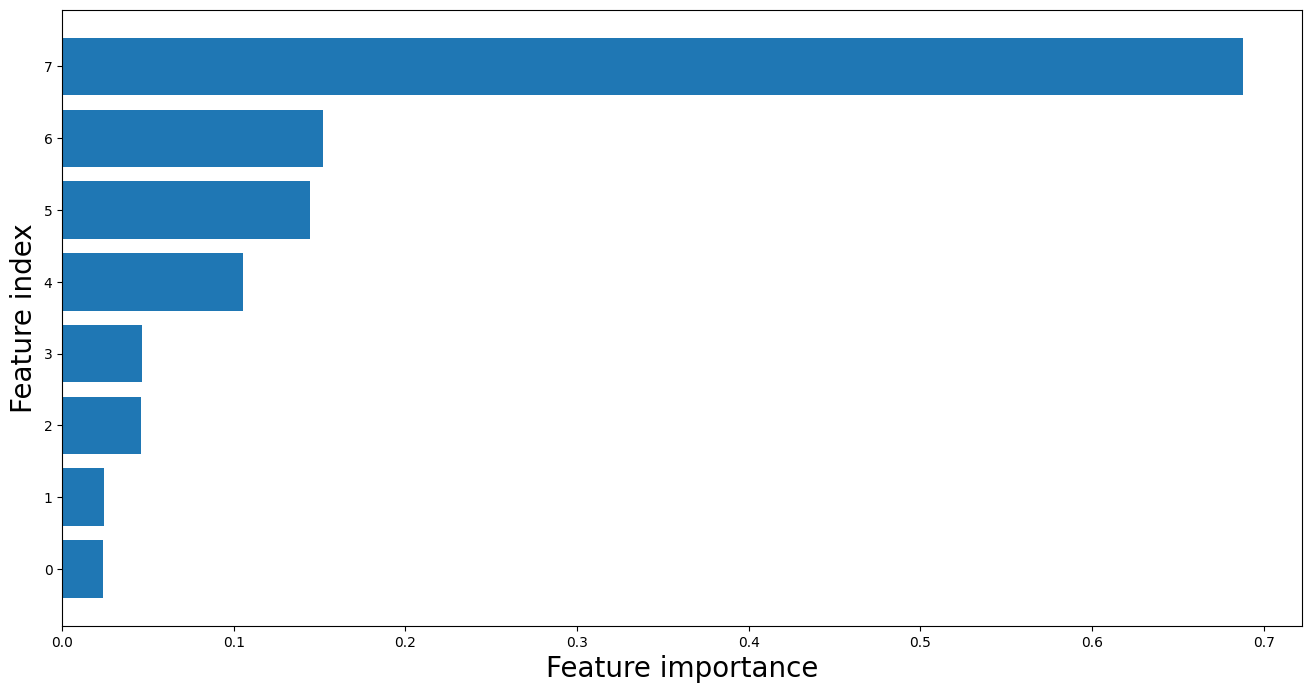

In [3]:
# Загрузка данных
ds = fetch_california_housing()

# Получим значения входных и выходных переменных
X, y = ds.data, ds.target
indexes = np.arange(len(y))
np.random.seed(654678)
np.random.shuffle(indexes)
X = X[indexes, :]
y = y[indexes]

# Посчитаем корреляции признаков с целевой переменной
features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)

# Нарисуем полученные корреляции
fig = plt.figure(figsize=(16, 8))
plt.barh(features_ind, corrs[importances_sort])
plt.xlabel('Feature importance', fontsize=20)
plt.ylabel('Feature index', fontsize=20)
X = X[:, importances_sort]

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Теперь давайте построим модели, в которых будет разное количество входных признаков, имеющих наибольшие абсолютные значения корреляции.

In [5]:
features_counts = np.arange(X.shape[1])

def scores_by_features_count(reg):
    scores = []
    for features_part in features_counts:
        X_part = X[:, importances_sort[features_part:]]
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_features_count(LinearRegression())
rf_scores = scores_by_features_count(RandomForestRegressor(n_estimators=100, max_depth=3))

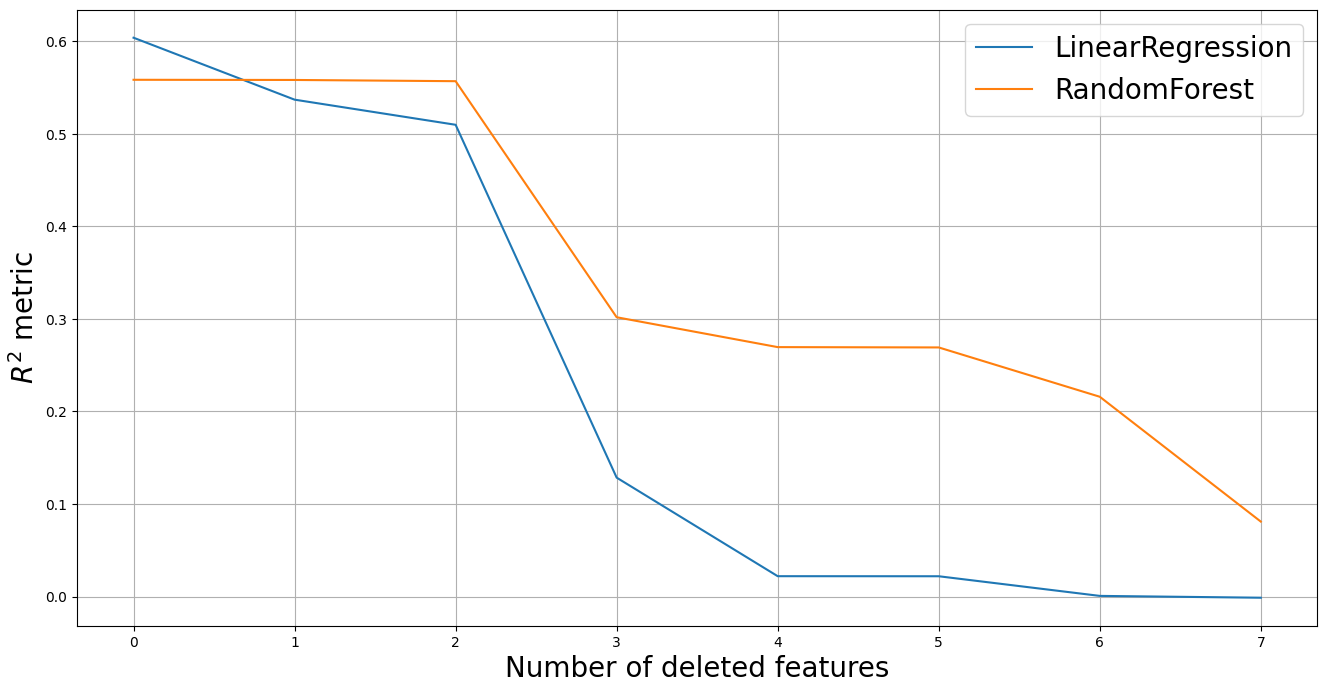

In [6]:
plt.figure(figsize=(16,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('Number of deleted features', fontsize=20)
plt.ylabel('$R^2$ metric', fontsize=20)
plt.grid()

Если мы захотим немного сократить потребление ресурсов, пожертвовав частью качества,
видно, что это можно сделать.

Для себя можете попробовать ответить на два вопроса, подумав или написав соответствующий код:
1. Означают ли полученные результаты, что отбор признаков по корреляции лучше случайного выбора множества признаков того же размера? Какой эксперимент поможет нам понять, так это или нет?
2. Что в подобной процедуре отбора признаков может привести к переобучению? Как этого можно было бы избежать?


## Метод главных компонент (Principal Component Analysis, PCA)



Выделение новых признаков путем их отбора часто дает плохие результаты, и в некоторых ситуациях такой подход практически бесполезен. Например, если мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о содержимом картинки. Поэтому признаки нужно как-то комбинировать.

__Метод главных компонент__ &mdash; один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков. В рамках метода делается два важных упрощения задачи:

1. Игнорируется целевая переменная, мы смотрим только на пространство входных признаков
2. Строится линейное преобразование исходных признаков, сохраняющее большую часть доступной информации

> П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является таким уж плохим. Это связано с тем, что часто у данных есть внутренняя структура в пространстве меньшей размерности, которая никак не связана с целевой переменной. Поэтому и оптимальные признаки можно строить, не глядя на ответ.

> П. 2 тоже сильно упрощает задачу, но далее мы рассмотрим и более сложные нелинейные методы.

### Теория

Что делает метод:

Пусть $X$ &mdash; матрица объекты-признаки с нулевым средним каждого признака, а $w$ &mdash; некоторый единичный вектор. Тогда $Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор, который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию вдоль этого направления). Формально получаем следующую оптимизационную задачу:

$$
\max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным значением. После этого все пространство проецируется на ортогональное дополнение к вектору $w$, и процесс повторяется.

### PCA на плоскости



Для начала посмотрим на метод PCA на плоскости, для того чтобы лучше понять, как он устроен. Попробуем специально сделать один из признаков более значимым и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного нормального распределения с нулевым математическим ожиданием.

In [7]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[4, 0],
         [0, 1]],
    size=1000
)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент.
В результате работы PCA из sklearn в `dec.components_` будут лежать главные направления (нормированные), а в `dec.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента.

Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их значимости.

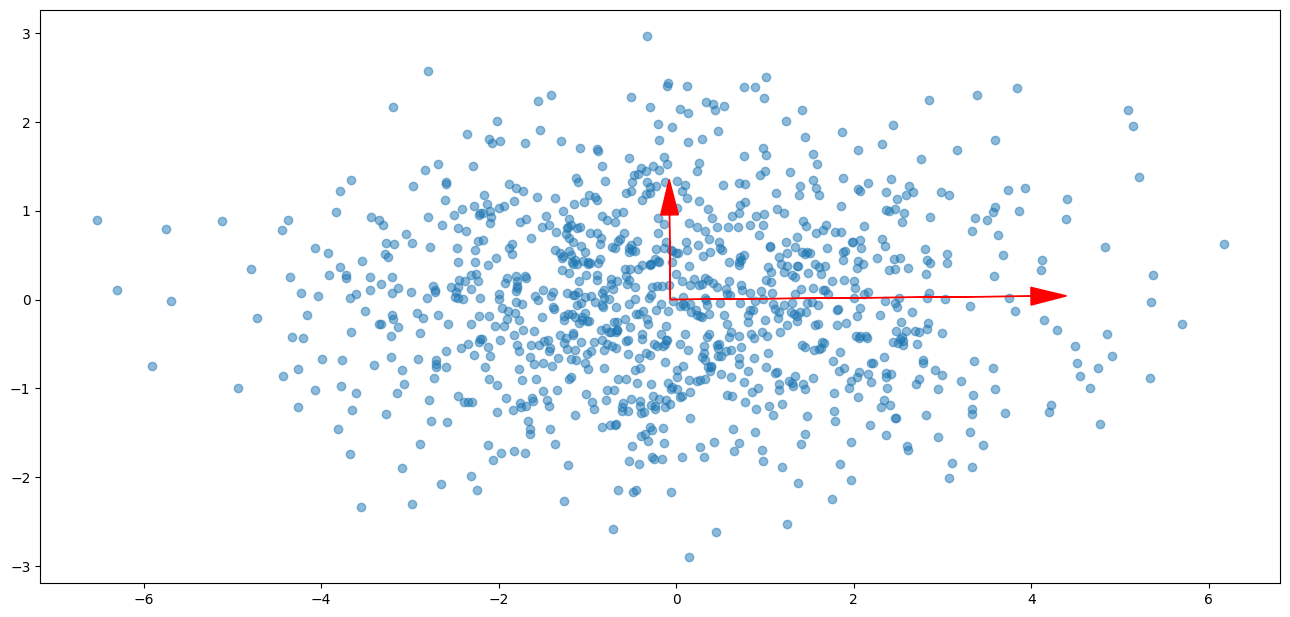

In [8]:
from sklearn.decomposition import PCA

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)

    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')

    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

Видим, что PCA правильно выделил главные компоненты. Но это, конечно, можно было сделать и просто посчитав
дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим,
что для PCA это ничего не изменит.

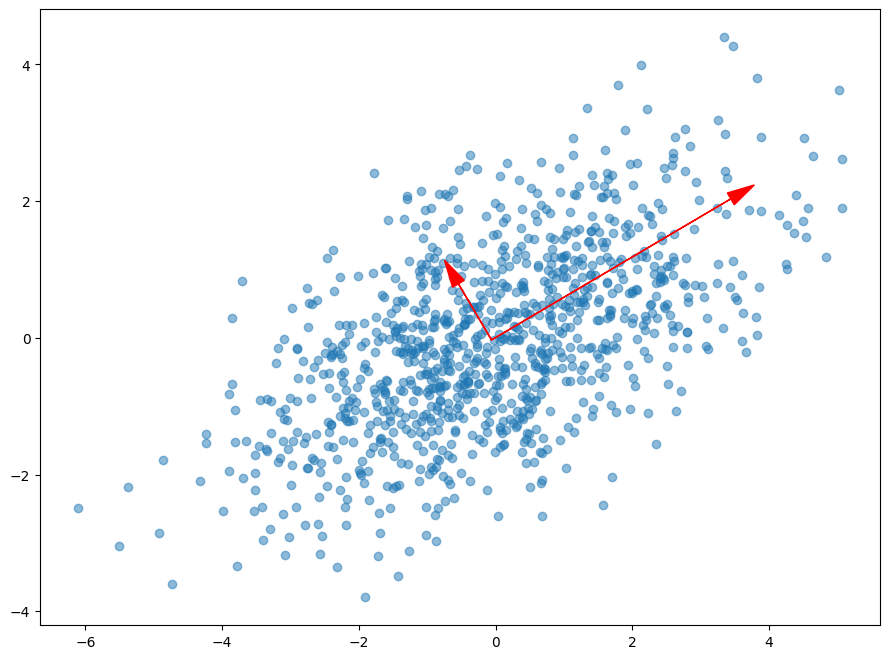

In [9]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже — пара примеров, где PCA отработал не так хорошо, и полученные им направления задают не очень хорошие признаки.

**Вопрос:** попробуйте объяснить, почему так произошло.

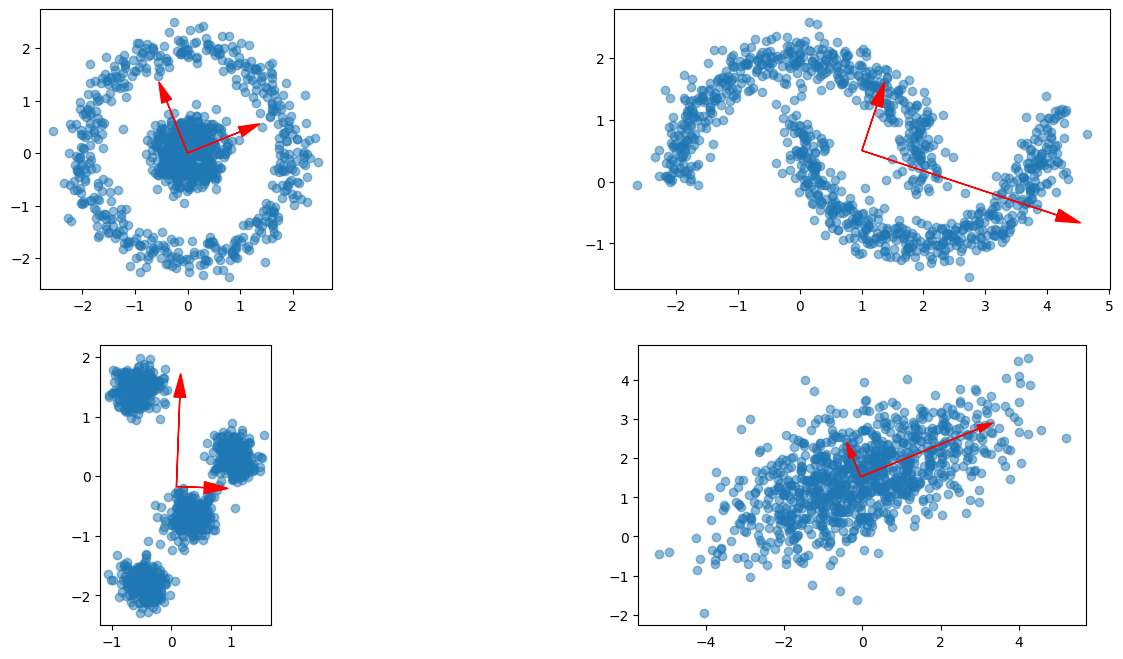

In [10]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)

data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5],
        cov=[[3, 1],
             [1, 1]],
        size=1000),
]

plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

### Лица людей



Рассмотрим датасет с фотографиями лиц людей и применим его к признакам PCA.

Ниже изображены примеры лиц из базы, и последняя картинка &mdash; это «среднее лицо».

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\rborn\scikit_learn_data


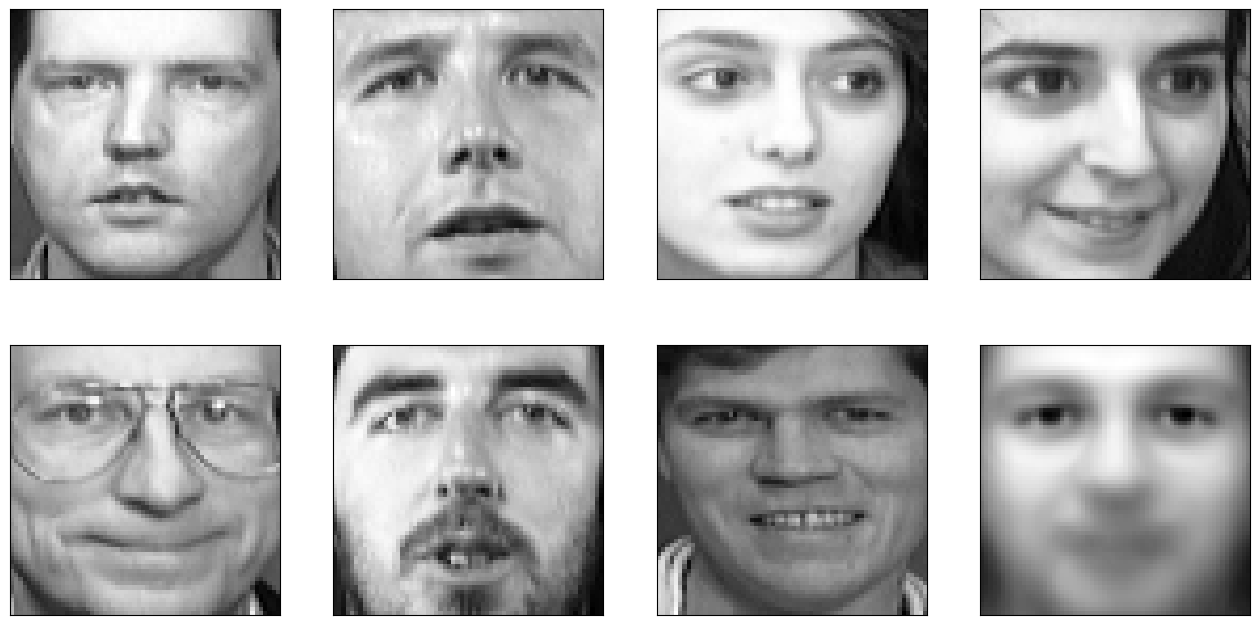

In [11]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)

mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты.

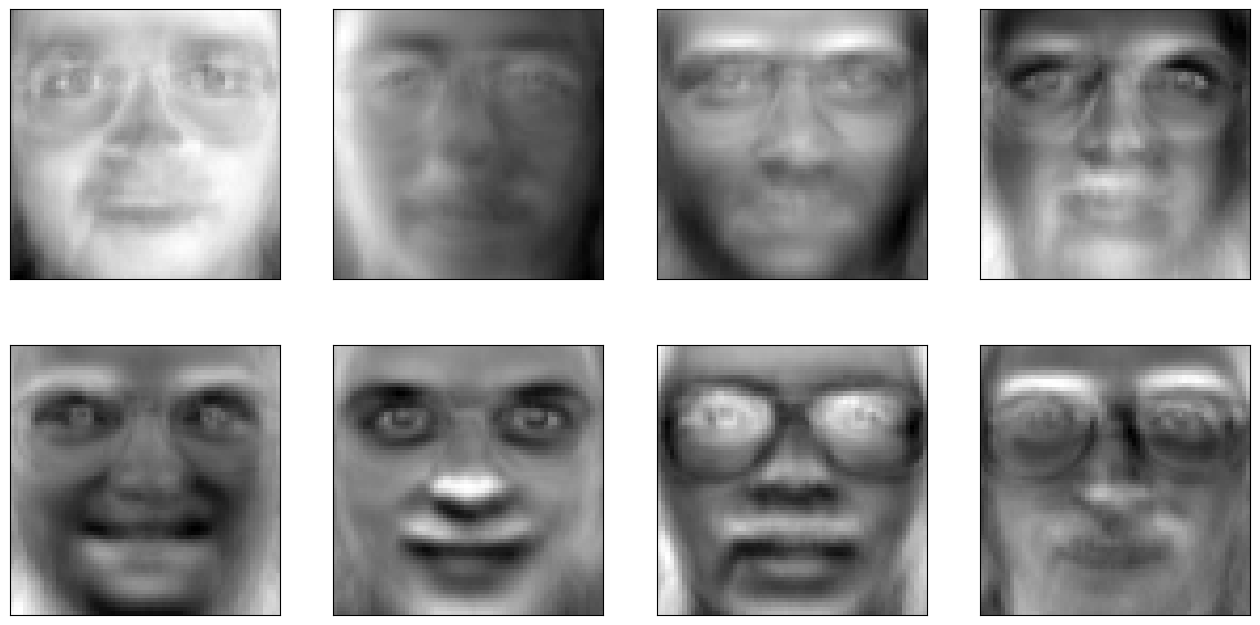

In [12]:
model_pca = PCA()
faces_images -= mean_face  # отнормировали данные к нулевому среднему
model_pca.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(model_pca.components_[i, :].reshape(image_shape), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

- Во-первых, новые признаки дают более высокое качество классификации

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(
    RandomForestClassifier(),
    {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]}, cv=5
)

In [14]:
%%time
gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

c:\Users\rborn\Desktop\study\NNDL\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.825
CPU times: total: 2min 7s
Wall time: 5min 6s


In [15]:
%%time
gscv_rf.fit(model_pca.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.925
CPU times: total: 45.1 s
Wall time: 1min 56s


На практике обычно выбирают столько главных компонент, чтобы оставить ~90 % дисперсии исходных данных.
В данном случае для этого достаточно выделить около 60 главных компонент, т.е. можно снизить размерность с 4 096 признаков до 60, потеряв только 10 % информации.

In [ ]:
faces_images.shape

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

 - Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются в новое пространство, и из него выкидываются самые незначимые признаки. Ниже приведены результаты сжатия в 20 раз

In [ ]:
base_size = image_shape[0] * image_shape[1]

def compress_and_show(compress_ratio):
    model_pca = PCA(n_components=int(base_size * compress_ratio))
    model_pca.fit(faces_images)

    faces_compressed = model_pca.transform(faces_images)

    # обратное преобразование
    faces_restored = model_pca.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())

compress_and_show(0.05)

Даже при сжатии в 50 раз лица остаются узнаваемыми.

In [ ]:
compress_and_show(0.02)

### PCA с ядрами



Так как PCA фактически работает не с исходными признаками, а с матрицей их ковариаций, можно использовать для ее вычисления вместо скалярного произведения $\langle x_i, x_j \rangle$ произвольное ядро $K(x_i, x_j)$. Это будет соответствовать переходу в другое пространство. Единственная проблема &mdash; непонятно, как подбирать ядро.

Ниже приведены примеры объектов в исходном пространстве (похожие группы обозначены одним цветом для наглядности) и результат их трансформации в новые пространства (для разных ядер). Если результаты получаются линейно разделимыми, значит мы выбрали подходящее ядро.

In [ ]:
from sklearn.decomposition import KernelPCA

def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1

    plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    kernels_params = [
        dict(kernel='rbf', gamma=10),
        dict(kernel='poly', gamma=10),
        dict(kernel='cosine', gamma=10),
    ]

    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_transformed = dec.fit_transform(X)

        plt.subplot(rows, cols, i + 2)
        plt.scatter(X_transformed[reds, 0], X_transformed[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_transformed[blues, 0], X_transformed[blues, 1], alpha=0.5, c='b')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')

np.random.seed(54242)
KPCA_show(*make_circles(n_samples=1000, factor=0.2, noise=0.1))

In [ ]:
np.random.seed(54242)
KPCA_show(*make_moons(n_samples=1000, noise=0.1))

## MNIST



Для тестирования будет использоваться типовой набор

In [ ]:
import seaborn as sns
from numpy import reshape
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Грузим датасет и нормируем

In [ ]:
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target
print(X.shape, y.shape)

Используем DataFrame структуру для дальнейшей работы с набором данных.

In [ ]:
# Преобразование набора данных в струкуру DataFrame
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe : {} '.format(df.shape))

np.random.seed(42)
rndperm = np.random.permutation(df.shape[0]) # Перемешиваем данные

Итого у нас 70 тысяч образцов и 784 признака.
Выведем полученные фреймы в следующем виде:



In [ ]:
# Выводим данные на графике
plt.gray()
fig = plt.figure(figsize=(16, 7))
for i in range (0, 15):
    ax = fig.add_subplot(3, 5, i+1, title="Digit: {}".format(str(df.loc[rndperm[i], 'label'])))
    ax.matshow(df.loc[rndperm[i], feat_cols].values.reshape((28, 28)).astype(float))
plt.show()

Сгенерируем первые три главные компоненты из исходных 784 измерений.

Параметр `n_components` определяет количество измерений, на которые будет произведена проекция, то есть до какого уровня мы желаем сократить размерность нашего набора данных.

Т.е., этот параметр определяет число главных компонент, представляющих собой n наиболее значимых собственных векторов матрицы данных, соответствующих самым большим собственным числам.

In [ ]:
# Уменьшение размерности данных при помощи PCA
pca = PCA(n_components=3)
df['pixel0'] = 0
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result [:, 0]
df['pca-two'] = pca_result [:, 1]
df['pca-three'] = pca_result [:, 2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm, :],
    legend="full",
    alpha=0.3
)

Представленный результат показывает, что два компонента определенно содержат некоторую информацию, особенно для конкретных цифр. Тем не менее, этого недостаточно, чтобы разделить их все.

Для наглядности выведем отображение трехмерной проекции результата:

In [ ]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=df.loc[rndperm, :]['pca-one'],
    ys=df.loc[rndperm, :]['pca-two'],
    zs=df.loc[rndperm, :]['pca-three'],
    c=df.loc[rndperm, :]['y'].astype(float),
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## TSNE (t-distributed Stohastic Neighbor Embedding)



В 2008 г. Хинтон вместе со своим аспирантом  придумал [новый метод визуализации данных](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

Основная идея метода состоит в поиске отображения из многомерного признакового пространства на плоскость (или в многомерное пространство меньшей размерности, но почти всегда выбирают 2D), чтобы точки, которые были далеко друг от друга, на плоскости тоже оказались удаленными, а близкие точки также отобразились на близкие. Т. е. neighbor embedding – это своего рода поиск нового представления данных, при котором сохраняется отношение соседства.

__T-Distributed Stochastic Neighbor Embedding (t-SNE)__ &mdash; метод для нелинейного снижения размерности и визуализации многомерных данных. В отличие от метода главных компонент, t-SNE основан на вероятностном подходе.

t-SNE минимизирует расхождение между двумя распределениями: распределением, которое измеряет попарные сходства объектов входных данных, и распределением, которое измеряет попарные сходства соответствующих низкоразмерных точек во вложении.

Для начала попробуем запустить алгоритм используя исходную размерность данных `(784)` и посмотрим, как он работает. Мы будем использовать только первые 10 000 семплов для запуска алгоритма, чтобы не грузить нашу машину с точки зрения памяти и мощности/времени. Для сравнения запустим PCA для выбранного подмножества.



In [ ]:
N = 10000
df_subset = df.loc[rndperm[:N], :].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca - one'] = pca_result[:, 0]
df_subset['pca - two'] = pca_result[:, 1]
df_subset['pca - three'] = pca_result[:, 2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Далее, можно пронаблюдать улучшение по сравнению с визуализацией при помощи PCA, полученную ранее. Мы видим, что цифры (точки) очень четко сгруппированы в свои собственные подгруппы.

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:, 0]
df_subset['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Выведем графики сравнения алгоритмов PCA и t-SNE.

In [ ]:
plt.figure(figsize=(16, 7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 7))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

Очевидно, что график с t-SNE выглядит презентабельней, т.к. у PCA есть существенное ограничение: он находит только линейные комбинации исходных признаков, если не добавить какое-нибудь ядро.

У метода есть параметр `Perplexity`, который отвечает за то, насколько сильно точки могут разлететься друг от друга.

Итоговая картинка может сильно поменяться при изменении `random_state`, что может усложнить интерпретацию. В целом по таким картинкам не стоит делать сильно далеко идущих выводов – не стоит гадать по кофейной гуще.

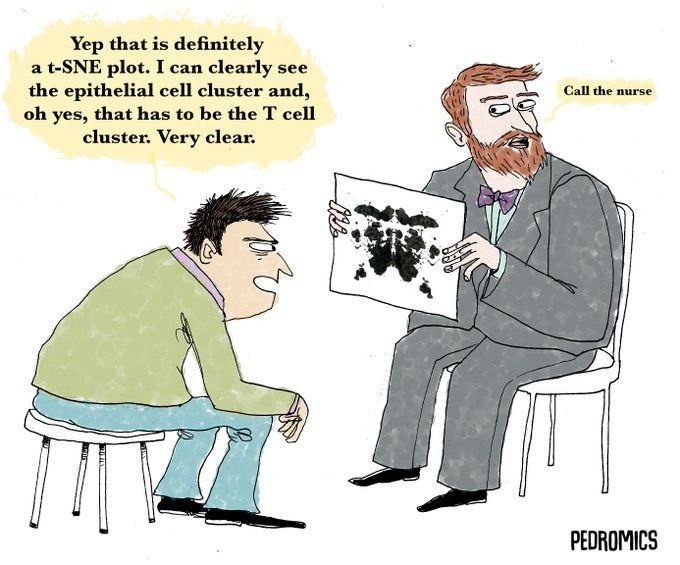

## UMAP

В 2018 г. был предложен еще один алгоритм нелинейного снижения размерности — [UMAP.](https://umap-learn.readthedocs.io/en/latest/) Он похож на TSNE, но работает быстрее и более эффективен.

Чтобы пролог к заданию лабораторной работы не был слишком долгим, предлагается ознакомиться подробней с методом вот [здесь](https://habr.com/ru/companies/newprolab/articles/350584/).

Подведём итоги:

- Процедура отбора признаков не всегда эффективно снижает размерность пространства; в некоторых случаях целесообразнее использовать альтернативные методы.
- Для линейного снижения размерности применяют метод главных компонент (PCA). Его эффективность повышается при предварительной нормализации данных, чтобы обеспечить схожий масштаб по всем признакам. Важно отметить, что PCA не учитывает целевую переменную.
- Для нелинейного снижения размерности широко применяются методы t-SNE и UMAP. Последний отличается относительно высокой скоростью работы и большей  наглядностью результата.
- Тем не менее, нелинейные методы, такие как t-SNE и UMAP, не подходят для снижения размерности новых данных. В подобных случаях более эффективными являются автокодировщики, основанные на нейронных сетях, и другие методы построения представлений данных.

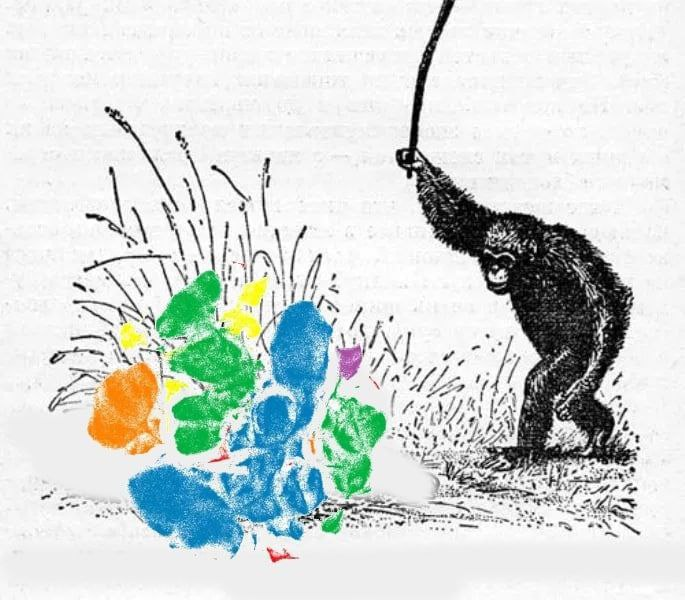

## Задание

1.  Используя PCA на целевом датасете, требуется сократить количество измерений, таким образом, чтобы параметр `сumulative explained variance` выдавал не меньше 80%. Вывести получившееся значение.

2. Cравнить три метода (PCA, t-SNE, UMAP) на наборе данных согласно своему варианту: вывести сводные графики, время работы. Можно считать на подвыборке из 10000 семплов, по аналогии выше.


### Дополнительное задание

Предлагается использовать быструю реализацию t-SNE метода [Multicore t-SNE]( https://github.com/DmitryUlyanov/Multicore-TSNE), привести сравнение по времени со `sklearn` реализацией.



### Варианты заданий:
Вы выбираете тот вариант задания, который соответствует вашему номеру в списке группы (НСГ). Если количество вариантов задания (К) меньше, чем НСГ, то студенты, имеющие НСГ, превышающие К, руководствуются следующим правилом:
$$ № Варианта = (НСГ – К + 1) $$


Список варинатов:
описание и ссылки на наборы, (все кроме FashionMNIST)
https://medmnist.com/
https://github.com/MedMNIST/MedMNIST

FashionMNIST - https://github.com/zalandoresearch/fashion-mnist


1. OrganCMNIST  
2. VesselMNIST3D  
3. PneumoniaMNIST  
4. OrganSMNIST  
5. OrganAMNIST  
6. BloodMNIST  
7. DermaMNIST  
8. SynapseMNIST3D  
9. BreastMNIST  
10. OCTMNIST  
11. NoduleMNIST3D  
12. FashionMnist
13. FractureMNIST3D  
14. RetinaMNIST  
15. PathMNIST  
16. TissueMNIST  
17. AdrenalMNIST3D  
18. ChestMNIST  
19. OrganMNIST3D  


## Источники




1. L. J. P. van der Maaten and G. E. Hinton. "Visualizing High-Dimensional Data Using t-SNE." *Journal of Machine Learning Research*, 9(Nov):2579-2605, 2008.

2. G. E. Hinton and S. T. Roweis. "Stochastic Neighbor Embedding." In *Advances in Neural Information Processing Systems*, volume 15, pages 833–840, Cambridge, MA, USA, 2002. The MIT Press.

3. R. A. Jacobs. "Increased rates of convergence through learning rate adaptation." *Neural Networks*, 1: 295–307, 1988.

4. Эксперименты с t-SNE на Python: [Алгоритм t-SNE](https://datareview.info/article/algoritm-t-sne-illyustrirovannyiy-vvodnyiy-kurs).

5. [Visualization of High-Dimensional Data using t-SNE](https://www.codeproject.com/Tips/788739/Visualization-of-High-Dimensional-Data-using-t-SNE).

6. L. J. P. van der Maaten. "Accelerating t-SNE using Tree-Based Algorithms." *Journal of Machine Learning Research*, 15(Oct):3221-3245, 2014.

7. [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/).

8. [Principal Component Regression vs Partial Least Squares Regression](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html).

9. [Linear Discriminant Analysis (LDA)](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html#).

10. [Visualizing Large-scale and High-dimensional Data](https://arxiv.org/abs/1602.00370).

11. [Isomap](https://scikit-learn.org/stable/modules/manifold.html#isomap).

12. [UMAP.](https://umap-learn.readthedocs.io/en/latest/)

13. [Подробнее про UMAP](https://pair-code.github.io/understanding-umap/)

## Task

### Part 1

In [2]:
import numpy as np
from medmnist import VesselMNIST3D
from torch.utils.data import ConcatDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
train_dataset = VesselMNIST3D(split='train', download=True)
val_dataset = VesselMNIST3D(split='val')
test_dataset = VesselMNIST3D(split='test')

full_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

Using downloaded and verified file: C:\Users\rborn\.medmnist\vesselmnist3d.npz


In [4]:
data = []
labels = []

for img, label in full_dataset:
    img_flat = img.flatten()
    data.append(img_flat)
    labels.append(label)

data = np.array(data)
labels = np.array(labels)

In [5]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [6]:
pca = PCA().fit(data_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

print(f"Number of components to explain at least 80% variance: {n_components_80}")

Number of components to explain at least 80% variance: 496


### Part 2

In [7]:
n_samples = min(10000, len(data_scaled))
data_sample = data_scaled[:n_samples]
labels_sample = labels[:n_samples]

In [8]:
import time
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Initialize dictionaries to store results
embeddings = {}
times = {}

# PCA
start_time = time.time()
pca_2d = PCA(n_components=2)
embeddings['PCA'] = pca_2d.fit_transform(data_sample)
times['PCA'] = time.time() - start_time

# t-SNE
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42)
embeddings['t-SNE'] = tsne.fit_transform(data_sample)
times['t-SNE'] = time.time() - start_time

# UMAP
start_time = time.time()
umap_2d = umap.UMAP(n_components=2, random_state=42)
embeddings['UMAP'] = umap_2d.fit_transform(data_sample)
times['UMAP'] = time.time() - start_time

c:\Users\rborn\Desktop\study\NNDL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rborn\Desktop\study\NNDL\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


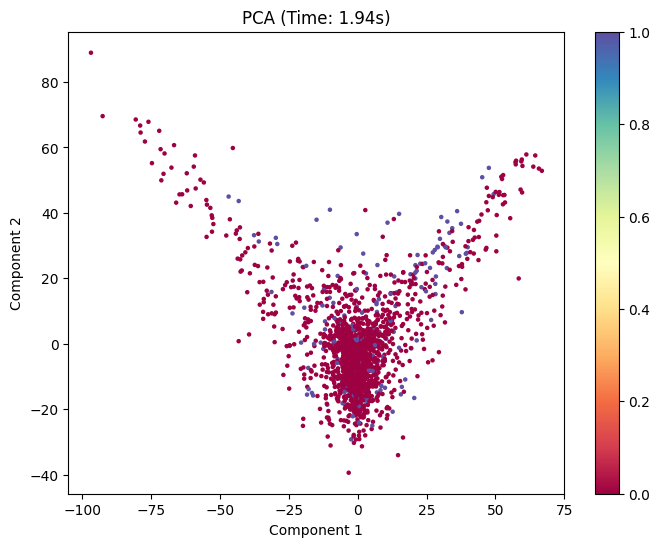

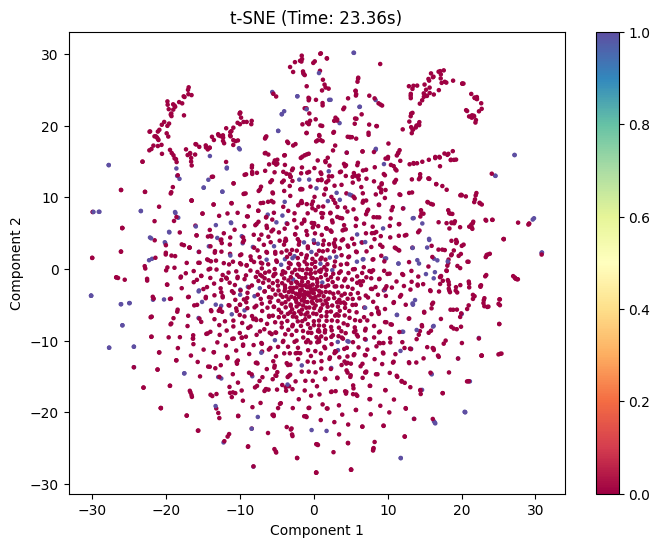

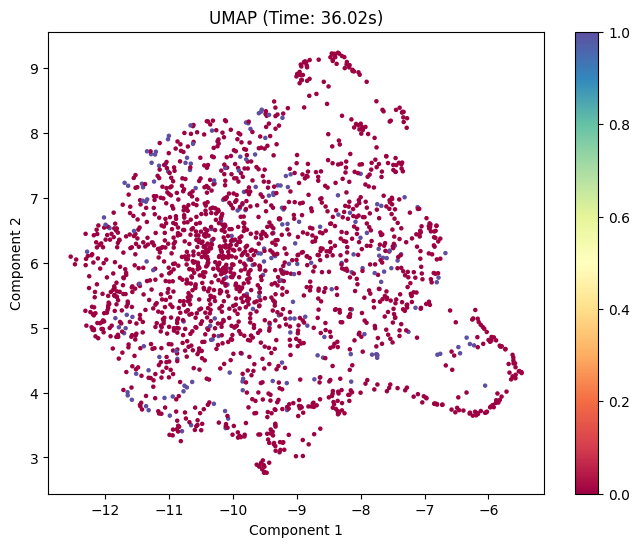

In [9]:
import matplotlib.pyplot as plt

def plot_embedding(data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels.squeeze(), cmap='Spectral', s=5)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar()
    plt.show()

# Plot embeddings
for method in embeddings:
    plot_embedding(embeddings[method], labels_sample, f"{method} (Time: {times[method]:.2f}s)")


In [10]:
for method in times:
    print(f"{method} execution time: {times[method]:.2f} seconds")

PCA execution time: 1.94 seconds
t-SNE execution time: 23.36 seconds
UMAP execution time: 36.02 seconds


### Additional Task

In [ ]:
from MulticoreTSNE import MulticoreTSNE as MTSNE

# Multicore t-SNE
start_time = time.time()
mtsne = MTSNE(n_components=2, n_jobs=4, random_state=42)
embeddings['Multicore t-SNE'] = mtsne.fit_transform(data_sample)
times['Multicore t-SNE'] = time.time() - start_time

In [ ]:
# Plot Multicore t-SNE embedding
plot_embedding(embeddings['Multicore t-SNE'], labels_sample, f"Multicore t-SNE (Time: {times['Multicore t-SNE']:.2f}s)")

In [ ]:
print(f"sklearn t-SNE execution time: {times['t-SNE']:.2f} seconds")
print(f"Multicore t-SNE execution time: {times['Multicore t-SNE']:.2f} seconds")